/Users/al1612le/data/bobsrepository/sub-938316/ses-2mo/anat/sub-938316_ses-2mo_space-INFANTMNIacpc_T1w.nii.gz
/Users/al1612le/data/bobsrepository/sub-938316/ses-2mo/anat/sub-938316_ses-2mo_space-INFANTMNIacpc_T2w.nii.gz
/Users/al1612le/data/bobsrepository/LR/sub-938316_ses-2mo_space-INFANTMNIacpc_T2w_LR.nii.gz


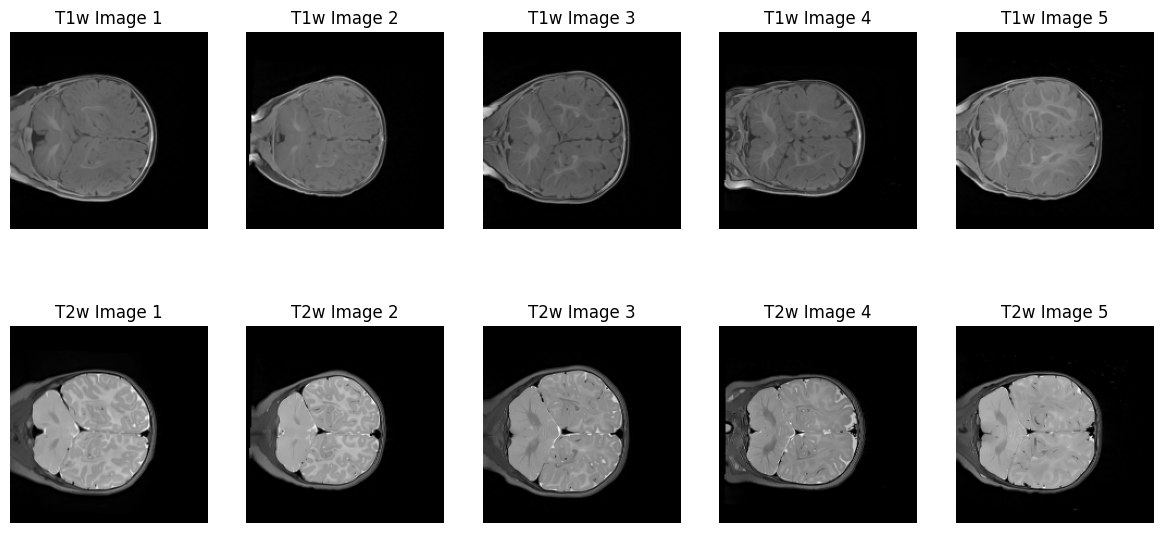

In [20]:
import pathlib as p
from preprocessing import split_dataset, scale_to_reference_img, pad_to_shape, normalize, get_patches, reconstruct_from_patches, create_LR_img_simple
from evaluations import calculate_metrics
import nibabel as nib

# interpolated
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(DATA_DIR.rglob("*T2w_LR.nii.gz"))

t1 = nib.load(t1_files[20]).get_fdata()
t2 = nib.load(t2_files[20]).get_fdata()
t2_LR = nib.load(t2_LR_files[61]).get_fdata()

print(t1_files[61])
print(t2_files[61])
print(t2_LR_files[61])

#plot 10 t1w and 10 t2w images in one row
import matplotlib.pyplot as plt
plt.figure(figsize=(30,7))
for i in range(5):
    t1 = nib.load(t1_files[i]).get_fdata()
    t2 = nib.load(t2_files[i]).get_fdata()
    plt.subplot(2, 10, i+1)
    plt.imshow(t1[:, t1.shape[2] // 2, :], cmap='gray')
    plt.title(f"T1w Image {i+1}")
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(t2[:, t2.shape[2] // 2, :], cmap='gray')
    plt.title(f"T2w Image {i+1}")
    plt.axis('off')
    i = i + 5
plt.show()